In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
from torch import nn, optim
from torchvision.models import resnet50
from torchsummary import summary
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

In [ ]:
import torch
from torch.utils.data import random_split, DataLoader
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_val_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform
)
test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform
)

len(train_val_dataset)

train_size = int(0.84 * len(train_val_dataset))
val_size = int(0.16 * len(train_val_dataset))
test_size = len(train_val_dataset) - train_size - val_size

train_dataset, val_dataset = random_split(
    train_val_dataset, [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

print(f"Train set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")


100%|██████████| 170M/170M [00:18<00:00, 9.18MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Train set size: 42000
Validation set size: 8000
Test set size: 10000


In [ ]:
resnet50_model = resnet50(pretrained=False)

resnet50_model.fc = nn.Linear(resnet50_model.fc.in_features, 10)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet50_model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)


In [ ]:
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, epochs=20, device='cuda', patience=15):
    model.to(device)
    train_loss, val_loss = [], []
    train_acc, val_acc = [], []

    best_val_loss = float('inf')
    epochs_without_improvement = 0

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        train_loss.append(running_loss / len(train_loader))
        train_acc.append(100. * correct / total)

        model.eval()
        val_running_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                val_running_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += targets.size(0)
                val_correct += predicted.eq(targets).sum().item()

        val_loss.append(val_running_loss / len(val_loader))
        val_acc.append(100. * val_correct / val_total)

        print(f"Epoch {epoch + 1}/{epochs}: Train Loss: {train_loss[-1]:.4f}, Val Loss: {val_loss[-1]:.4f}, "
              f"Train Acc: {train_acc[-1]:.2f}%, Val Acc: {val_acc[-1]:.2f}%")

        if epoch == 0 or epoch == epochs - 1:
            torch.save(model.state_dict(), f"model_epoch_{epoch + 1}.pth")

        if val_loss[-1] < best_val_loss:
            best_val_loss = val_loss[-1]
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Validation loss did not improve for {patience} epochs. Stopping training early.")
                torch.save(model.state_dict(), f"model_epoch_{epoch + 1}.pth")
                break

    return train_loss, val_loss, train_acc, val_acc


In [ ]:
epochs=[10,20,30,40,50]

train_loss, val_loss, train_acc, val_acc = train_and_validate(resnet50_model, train_loader, val_loader, criterion, optimizer, epochs=50, device=device)


Epoch 1/50: Train Loss: 3.3320, Val Loss: 3.9791, Train Acc: 25.29%, Val Acc: 31.11%
Epoch 2/50: Train Loss: 2.3442, Val Loss: 4.0474, Train Acc: 35.74%, Val Acc: 39.62%
Epoch 3/50: Train Loss: 1.9872, Val Loss: 2.8286, Train Acc: 41.92%, Val Acc: 44.14%
Epoch 4/50: Train Loss: 1.8438, Val Loss: 3.9708, Train Acc: 45.40%, Val Acc: 48.09%
Epoch 5/50: Train Loss: 1.6242, Val Loss: 2.1924, Train Acc: 50.17%, Val Acc: 50.41%
Epoch 6/50: Train Loss: 1.4722, Val Loss: 2.6767, Train Acc: 53.87%, Val Acc: 53.08%
Epoch 7/50: Train Loss: 1.3428, Val Loss: 2.8871, Train Acc: 57.08%, Val Acc: 56.40%
Epoch 8/50: Train Loss: 1.1936, Val Loss: 1.7364, Train Acc: 60.61%, Val Acc: 58.59%
Epoch 9/50: Train Loss: 1.0849, Val Loss: 1.5026, Train Acc: 63.86%, Val Acc: 61.54%
Epoch 10/50: Train Loss: 0.9947, Val Loss: 1.5842, Train Acc: 67.17%, Val Acc: 61.10%
Epoch 11/50: Train Loss: 0.9050, Val Loss: 1.9583, Train Acc: 69.59%, Val Acc: 63.73%
Epoch 12/50: Train Loss: 0.8080, Val Loss: 3.0532, Train Acc: 7

In [ ]:
def test(model, test_loader, device='cuda'):
    model.eval()
    test_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    test_acc = 100. * correct / total
    print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_acc:.2f}%")
    return test_acc

test_acc = test(resnet50_model, test_loader, device=device)


Test Loss: 1.3543, Test Accuracy: 68.90%


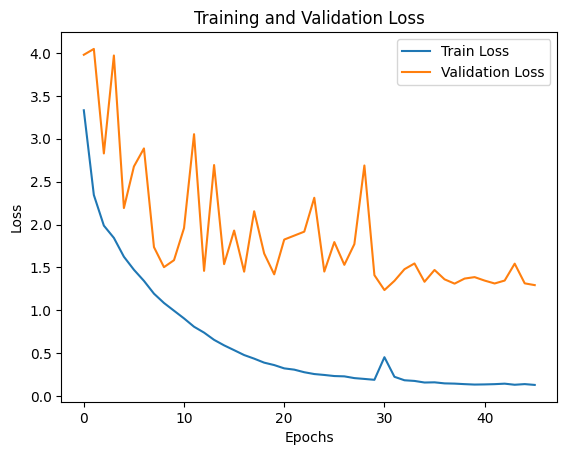

In [ ]:
plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()


<ipython-input-9-4a1752c2d46d>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(epoch_weights_path))


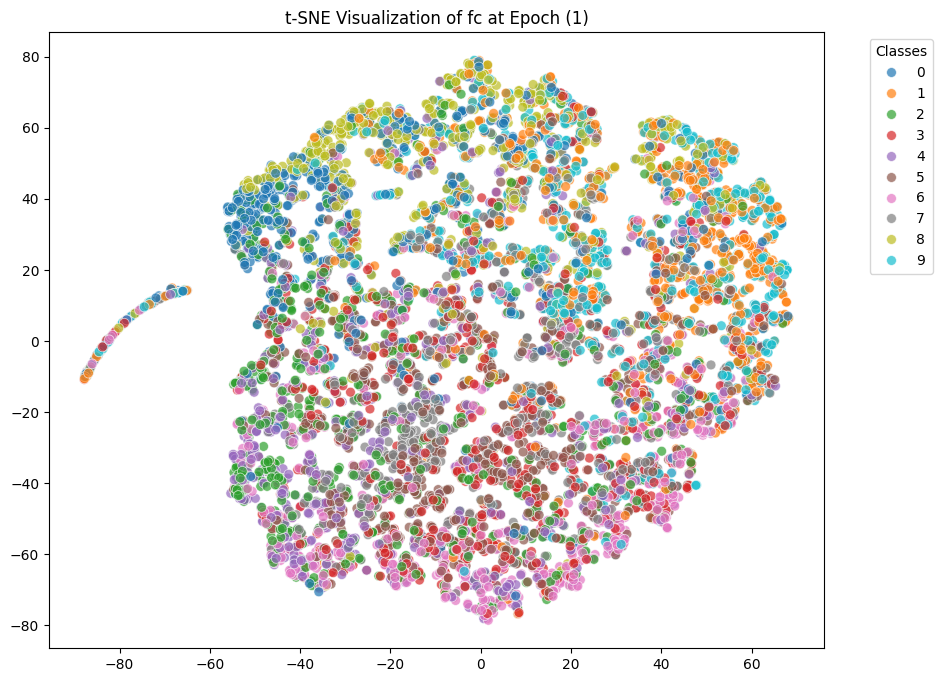

<ipython-input-9-4a1752c2d46d>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(epoch_weights_path))


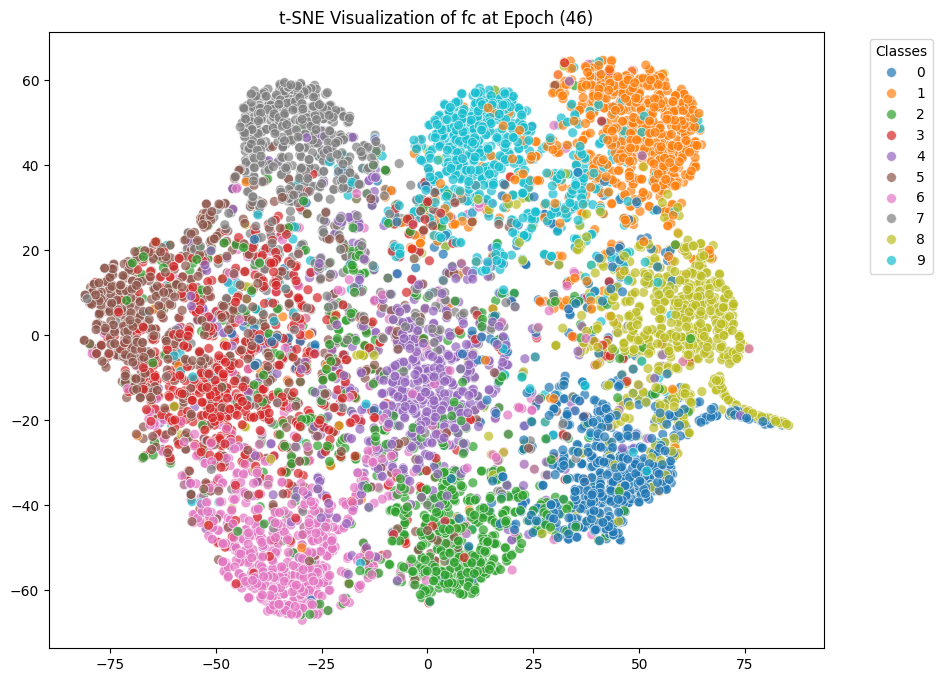

In [ ]:
import seaborn as sns
def tsne_visualization_from_model_weights(model, loader, device, layer_name, epoch_weights_path):
    model.load_state_dict(torch.load(epoch_weights_path))
    model.to(device)
    model.eval()

    layer_outputs = []

    def hook_fn(module, input, output):
        layer_outputs.append(output)

    for name, module in model.named_modules():
        if name == layer_name:
            module.register_forward_hook(hook_fn)

    features, labels = [], []

    for inputs, targets in loader:
        inputs = inputs.to(device)
        with torch.no_grad():
            _ = model(inputs)
        features.append(layer_outputs[-1].cpu().view(inputs.size(0), -1).numpy())
        labels.append(targets.numpy())
        layer_outputs.clear()

    features = np.concatenate(features)
    labels = np.concatenate(labels)

    tsne = TSNE(n_components=2, random_state=42)
    reduced_features = tsne.fit_transform(features)

    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        x=reduced_features[:, 0], y=reduced_features[:, 1],
        hue=labels, palette='tab10', s=50, alpha=0.7
    )
    plt.title(f"t-SNE Visualization of {layer_name} at Epoch ({epoch_weights_path.split('_')[-1].split('.')[0]})")
    plt.legend(title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

tsne_visualization_from_model_weights(
    resnet50_model, val_loader, device, layer_name="fc", epoch_weights_path="model_epoch_1.pth"
)
tsne_visualization_from_model_weights(
    resnet50_model, val_loader, device, layer_name="fc", epoch_weights_path=f"model_epoch_{len(train_loss)}.pth"
)


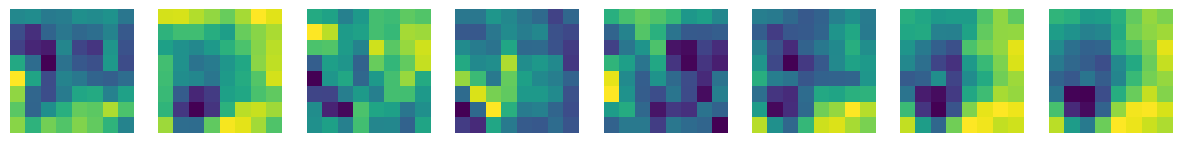

In [ ]:
import seaborn as sns

def visualize_activation_maps(model, test_loader, layer_name, device):
    activation_maps = {}

    def hook_fn(module, input, output):
        activation_maps[layer_name] = output

    for name, module in model.named_modules():
        if name == layer_name:
            module.register_forward_hook(hook_fn)

    model.eval()
    inputs, _ = next(iter(test_loader))
    inputs = inputs[0].unsqueeze(0).to(device)
    with torch.no_grad():
        _ = model(inputs)

    activations = activation_maps[layer_name].squeeze(0).cpu()
    num_channels = activations.shape[0]

    fig, axes = plt.subplots(1, min(8, num_channels), figsize=(15, 5))
    for i, ax in enumerate(axes):
        ax.imshow(activations[i].numpy(), cmap='viridis')
        ax.axis('off')
    plt.show()




visualize_activation_maps(resnet50_model, test_loader, layer_name='layer1.0.conv1', device=device)


